In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/MA')
print(os.listdir(os.getcwd()))
import json
import pandas as pd
import gzip
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import Sequence
from sklearn.metrics import log_loss, roc_auc_score
import copy
import scipy

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['SIG Proceedings Template-Jan2015 Zip', '.DS_Store', 'we_data.zip', 'sig-proceedings-template-may2015-zip.zip', 'click_predictions', 'bid_predictions', 'payprice_predictions', 'Click Prediction Grid Search.gsheet', 'Payprice_Prediction.ipynb', 'Preprocessing1.ipynb', 'CTR Prediction.ipynb', 'data2', 'data', 'MA_Feature_Engineering.ipynb', 'League_of_Agents.ipynb']


In [0]:
data=pd.read_csv('data/validation1.csv',dtype={'slotvisibility':str,'slotformat':str,'creative':str,'slotid2':str})
# click_prediction=np.fromfile('click_predictions/validation_predictions_new0.bin').astype(float).reshape(1,303925)

click_prediction=np.expand_dims(np.asarray(pd.read_csv('click_predictions/Luke_xgb_predictor320_maxdepth7_gamma004_ctr_prediction_validation_no_creative.csv',header=None)[0]),axis=0)
payprice_prediction=np.fromfile('payprice_predictions/validation_payprice_prediction1.bin').astype(float).reshape(303925,31)
validation=np.hstack((np.concatenate((np.asarray([data.click]),np.asarray([data.payprice]),np.asarray([data.slotprice]),click_prediction),axis=0).T,payprice_prediction))

In [0]:
class agent_constant(object):
  
  def __init__(self,parameter=[10]):
    self.type='constant'
    self.constant=int(parameter[0])
  
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    bidprice=self.constant*np.ones(10000).astype(int)
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
  
  def learn(self):
    pass
  
  def mutate(self):
    self.constant=max(self.constant+int(np.random.normal(0,10)),0)
  
#################################################  

class agent_random(object):
  
  def __init__(self,parameter=[5,20]):
    self.type='random'
    self.lower_bound=int(parameter[0])
    self.upper_bound=int(parameter[1])
    
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    bidprice=np.random.randint(self.lower_bound,self.upper_bound,size=(10000))
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
  
  def learn(self):
    pass
  
  def mutate(self):
    self.lower_bound=max(self.lower_bound+int(np.random.normal(0,10)),0)
    self.upper_bound=max(self.upper_bound+int(np.random.normal(0,10)),0)
    self.lower_bound,self.upper_bound=sorted([self.lower_bound,self.upper_bound])
    if self.lower_bound==self.upper_bound:
      self.upper_bound+=1
      
###################################################

class agent_linear(object):
  
  def __init__(self,parameter=[150]):
    self.type='linear           '
    self.basebid=int(parameter[0])
    
  
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    
    a=click_prediction[n_bids:n_bids+10000].copy()
    a*=np.exp(np.random.normal(0,2,size=a.shape))
    a/=np.amax(a)
    
    bidprice=np.asarray(self.basebid*a).astype(int)
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
    
  
  def learn(self):
    pass
  
  def mutate(self):
    self.basebid=max(int(self.basebid*np.random.normal(0,2)),0)

    
##################################################
    
class agent_quadratic(object):
  
  def __init__(self,parameter=[100]):
    self.type='quadratic        '
    self.basebid=int(parameter[0])
    
    
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    bidprice=np.asarray(self.basebid*(click_prediction[n_bids:n_bids+10000]**2)).astype(int)
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
  
  def learn(self):
    pass
  
  def mutate(self):
    self.basebid=max(int(self.basebid*np.random.normal(0,2)),0)
    
    
###################################################

class agent_bounded_linear(object):
  
  def __init__(self,parameter=[150,-3,-1]):
    self.type='bounded linear   '
    self.basebid=int(parameter[0])
    self.lowerbound=parameter[1]
    self.upperbound=parameter[2]
  
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    click_prediction=click_prediction[n_bids:n_bids+10000].copy()
    click_prediction[click_prediction<10**self.lowerbound]=0
    click_prediction[click_prediction>10**self.upperbound]=0
    bidprice=np.asarray(self.basebid*click_prediction).astype(int)
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
  
  def learn(self):
    pass
  
  def mutate(self):
    self.basebid=max(int(self.basebid*np.random.normal(0,2)),0)
    self.lowerbound=min(self.lowerbound+np.random.normal(0,1),0)
    self.upperbound=min(self.upperbound+np.random.normal(-1,1),0)
    self.lowerbound,self.upperbound=sorted([self.lowerbound,self.upperbound])
    
##################################################
    
class agent_bounded_quadratic(object):
  
  def __init__(self,parameter=[100,-3,-1]):
    self.type='bounded quadratic'
    self.basebid=int(parameter[0])
    self.lowerbound=parameter[1]
    self.upperbound=parameter[2]
    
    
  def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
    click_prediction=click_prediction[n_bids:n_bids+10000].copy()
    click_prediction[click_prediction<10**self.lowerbound]=0
    click_prediction[click_prediction>10**self.upperbound]=0
    bidprice=np.asarray(self.basebid*(click_prediction**2)).astype(int)
    return bidprice[(np.cumsum(bidprice)<=remain_budget)*(np.arange(len(bidprice))<n_obs-n_bids)]
  
  def learn(self):
    pass
  
  def mutate(self):
    self.basebid=max(int(self.basebid*np.random.normal(0,2)),0)
    self.lowerbound=min(self.lowerbound+np.random.normal(0,1),0)
    self.upperbound=min(self.upperbound+np.random.normal(-1,1),0)
    self.lowerbound,self.upperbound=sorted([self.lowerbound,self.upperbound])
  
####################################################  
  
# class agent_lp(object):
  
#   def __init__(self,parameter=[0.2,100,0.1]):
#     self.winning_rate=parameter[0]
#     self.batch_size=parameter[1]
#     self.threshold=parameter[2]
    
#   def bid(self,slotprice,click_prediction,budget,remain_budget,n_bids,n_obs,payprice_prediction):
#     batch_size=int(min(min(self.batch_size,n_obs-n_bids),n_obs*remain_budget/budget))
#     expected_spend=budget*batch_size/n_obs
#     if batch_size>0:
#       click_prediction=click_prediction[n_bids:n_bids+batch_size]
#       payprice_prediction=payprice_prediction[n_bids:n_bids+batch_size]
#       payprice_cdf=np.cumsum(payprice_prediction,axis=-1)
#       x0=(np.count_nonzero(payprice_cdf<self.threshold,axis=-1)-1)*10
#       x1=(np.count_nonzero(payprice_cdf<(1-self.threshold),axis=-1)+1)*10
#       bidprice=scipy.optimize.linprog(click_prediction/(x0-x1),A_eq=np.ones([1,batch_size]),b_eq=np.asarray(expected_spend/self.winning_rate).astype(int),bounds=list(zip(np.zeros(len(x0)),x1))).x
#       if isinstance(bidprice,float):
#         bidprice=np.zeros(0)
#       else:
#         bidprice=bidprice[(np.cumsum(bidprice)<=remain_budget)].astype(int)
#     else:
#       bidprice=np.zeros(0)
#     return bidprice
#   def learn(self):
#     pass
  
#   def mutate(self):
#     self.batch_size=max(self.batch_size+int(np.random.normal(0,100)),10)
#     self.threshold=max(self.threshold+int(np.random.normal(0,0.05)),0)

In [0]:
class bidding_environment(object):

  def __init__(self):
    self.round=0
    self.impression=[]
    self.click=[]
    self.CTR=[]
    self.spend=[]
    self.CPM=[]
    self.CPC=[]
    self.TBV=[]
        
  def get_data(self,dataset,ds_rate=1,budget=6250/303375):
    if ds_rate<1:
      dataset=dataset[np.random.choice(len(dataset),int(len(dataset)*ds_rate),replace=False)]
    self.click_label=dataset[:,0].astype(int)
    self.payprice=np.expand_dims(dataset[:,1].astype(int),axis=1)
    self.slotprice=dataset[:,2].astype(int)
    self.click_prediction=dataset[:,3].astype(float)
    self.payprice_prediction=dataset[:,4:].astype(float)
    self.n_obs=len(dataset)
    self.budget=int(self.n_obs*budget)*1000
  
  def get_agents(self,dic_of_agents):
    self.agents=[]
    self.n_agents=0
    if isinstance(dic_of_agents,list):
      self.agents=dic_of_agents
      self.n_agents=len(self.agents)
    if isinstance(dic_of_agents,dict):
      for agent_type in dic_of_agents.keys():
        for agent_instance in range(len(dic_of_agents[agent_type])):
          self.n_agents+=1
          parameter=dic_of_agents[agent_type][agent_instance]
          
          #####################################################
          if agent_type=='constant':
            self.agents.append(agent_constant(parameter))
          if agent_type=='random':
            self.agents.append(agent_random(parameter))
          if agent_type=='linear':
            self.agents.append(agent_linear(parameter))
          if agent_type=='quadratic':
            self.agents.append(agent_quadratic(parameter))
          if agent_type=='bounded_linear':
            self.agents.append(agent_bounded_linear(parameter))
          if agent_type=='bounded_quadratic':
            self.agents.append(agent_bounded_quadratic(parameter))  
          
          if agent_type=='lp':
            self.agents.append(agent_lp(parameter))
          #####################################################

  def bidding_round(self):
    all_bidprices=np.hstack((self.payprice,np.zeros([self.n_obs,self.n_agents]).astype(int)))
    all_winners=np.zeros(all_bidprices.shape).astype(bool)
    evaluated_bids=0
    n_bids=np.zeros(self.n_agents).astype(int)
    remain_budgets=self.budget*np.ones(self.n_agents+1).astype(int)
    while evaluated_bids<self.n_obs:
      for i in np.nonzero(n_bids==evaluated_bids)[0]:
        bidprices=self.agents[i].bid(self.slotprice,self.click_prediction,self.budget,remain_budgets[i+1],n_bids[i],self.n_obs,self.payprice_prediction)
        if len(bidprices)>0:
          n_bids[i]+=len(bidprices)
          all_bidprices[evaluated_bids:n_bids[i],i+1]=bidprices
        else:
          n_bids[i]=self.n_obs
      batch_end=np.amin(n_bids)     
      batch_bidprices=all_bidprices[evaluated_bids:batch_end].copy()
      batch_bidprices[batch_bidprices==np.amax(batch_bidprices,axis=1,keepdims=True)]=-1
      batch_winners=batch_bidprices<0
      for i in np.nonzero(np.count_nonzero(batch_winners,axis=1)-1)[0]:
        j=np.random.choice(np.nonzero(batch_winners[i])[0],1)
        batch_winners[i]=False
        batch_winners[i,j]=True  
      remain_budgets-=np.amax(batch_bidprices,axis=1)@batch_winners
      all_winners[evaluated_bids:batch_end]=batch_winners
      evaluated_bids=batch_end
      
#       print(n_bids,'\t',remain_budgets)
#       print(bidprices)
#     print(n_bids,'\t',remain_budgets)
  
    self.impression.append(np.sum(all_winners,axis=0))
    self.click.append(self.click_label@all_winners)
    self.CTR.append(100*self.click[-1]/self.impression[-1])
    self.spend.append((self.budget-remain_budgets)/1000)
    self.CPM.append(1000*self.spend[-1]/self.impression[-1])
    self.CPC.append(self.spend[-1]/self.click[-1])
    self.TBV.append(np.sum(all_bidprices,axis=0))
    
    ########################################
#     print('round     \t',self.round)
#     print('impression\t',self.impression[-1])
#     print('click     \t',self.click[-1])
#     print('CTR       \t',self.CTR[-1])
#     print('spend     \t',self.spend[-1])
    ########################################
    self.round+=1
#     plt.hist(all_bidprices[:,1],bins=50)

    return all_bidprices

  def population_evolve(self,fail_rate=0.4,top_rate=0.2):
    #######################
    KPI=self.click[-1][1:]
    #######################
    rank_idx=np.flip(np.argsort(KPI),axis=0)
    new_generation_agents=[]
    for i in range(int(self.n_agents*(1-fail_rate))):
      new_generation_agents.append(self.agents[rank_idx[i]])
      new_generation_agents[i].learn()
    for i in range(int(self.n_agents*top_rate)):
      for j in range(int(fail_rate/top_rate)):
        child_agent=copy.copy(new_generation_agents[i])
        child_agent.mutate()
        new_generation_agents.append(child_agent)
    self.agents=new_generation_agents
    self.n_agents=len(self.agents)
    n_top_agents=10
    for i in range(n_top_agents):
      print(i,'\t',self.agents[i].__dict__,'  \t',self.click[-1][rank_idx[i]+1],'\t',self.impression[-1][rank_idx[i]+1],'\t',self.spend[-1][rank_idx[i]+1],'\t',self.CTR[-1][rank_idx[i]+1],'\t',self.CPM[-1][rank_idx[i]+1])
      
    return self.agents

In [154]:
dic_of_agents={}
# dic_of_agents['constant']=np.random.randint(50,150,size=(10,1))
# a=np.random.randint(0,100,size=(10,1))
# b=a+np.random.randint(10,100,size=(10,1))
# dic_of_agents['random']=np.hstack((a,b))
dic_of_agents['linear']=50000*np.ones([30,1])
# dic_of_agents['quadratic']=np.random.randint(100,100000,size=(10,1))
# basebid=np.random.randint(1000,10000,size=(30,1))
# upperbound=np.zeros([30,1])
# lowerbound=upperbound-10*np.random.rand(30,1)
# dic_of_agents['bounded_linear']=np.concatenate((basebid,lowerbound,upperbound),axis=1)
# basebid=np.random.randint(1000,100000,size=(10,1))
# upperbound=np.zeros([10,1])
# lowerbound=upperbound-10*np.random.rand(10,1)
# dic_of_agents['bounded_quadratic']=np.concatenate((basebid,lowerbound,upperbound),axis=1)
myenv=bidding_environment()
myenv.get_data(validation)
myenv.get_agents(dic_of_agents)
n_rounds=100

bidprices=[]
agents=[]

for i in range(n_rounds):
  print('round',i)
  bidprices.append(myenv.bidding_round())
  agents.append(myenv.population_evolve())

round 0
0 	 {'type': 'linear           ', 'basebid': 50000}   	 13 	 9414 	 5615.237 	 0.13809220310176334 	 596.4772678988741
1 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 10537 	 6260.804 	 0.1043940400493499 	 594.1732941064819
2 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 10599 	 6260.031 	 0.10378337579016889 	 590.6246815737334
3 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 8269 	 4973.31 	 0.13302696819446125 	 601.4403192647237
4 	 {'type': 'linear           ', 'basebid': 50000}   	 10 	 10140 	 5798.294 	 0.09861932938856016 	 571.823865877712
5 	 {'type': 'linear           ', 'basebid': 50000}   	 10 	 9303 	 5496.114 	 0.10749220681500592 	 590.7894227668494
6 	 {'type': 'linear           ', 'basebid': 50000}   	 10 	 8526 	 5059.683 	 0.11728829462819611 	 593.4415904292752
7 	 {'type': 'linear           ', 'basebid': 50000}   	 8 	 9446 	 5925.646 	 0.08469193309337286 	 627.3180182087656
8 	 {'type': 'linear           ', 'basebi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


0 	 {'type': 'linear           ', 'basebid': 50000}   	 15 	 12368 	 6259.901 	 0.12128072445019406 	 506.13688551099614
1 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 12310 	 6155.564 	 0.08935824532900082 	 500.04581640942325
2 	 {'type': 'linear           ', 'basebid': 175820}   	 11 	 9276 	 6256.156 	 0.11858559724018973 	 674.4454506252695
3 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 8862 	 4207.525 	 0.12412547957571654 	 474.7827804107425
4 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 10911 	 5171.465 	 0.10081569058748052 	 473.96801393089544
5 	 {'type': 'linear           ', 'basebid': 50000}   	 11 	 10519 	 5328.441 	 0.10457267801121779 	 506.5539499952467
6 	 {'type': 'linear           ', 'basebid': 60361}   	 10 	 11842 	 6247.111 	 0.0844451950684006 	 527.5385070089512
7 	 {'type': 'linear           ', 'basebid': 50000}   	 10 	 11763 	 6024.713 	 0.08501232678738417 	 512.1748703562016
8 	 {'type': 'linear           ', 'base

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide


0 	 {'type': 'linear           ', 'basebid': 46941}   	 17 	 13015 	 5342.868 	 0.13061851709565886 	 410.5161736457933
1 	 {'type': 'linear           ', 'basebid': 50000}   	 15 	 13829 	 5849.86 	 0.10846771277749656 	 423.01395617904404
2 	 {'type': 'linear           ', 'basebid': 50000}   	 14 	 13788 	 5765.812 	 0.10153756890049319 	 418.1760951552074
3 	 {'type': 'linear           ', 'basebid': 50000}   	 12 	 13076 	 5202.468 	 0.09177118384827164 	 397.8638727439584
4 	 {'type': 'linear           ', 'basebid': 50000}   	 12 	 14185 	 5737.279 	 0.08459640465280226 	 404.4609799083539
5 	 {'type': 'linear           ', 'basebid': 50000}   	 12 	 13870 	 5727.382 	 0.08651766402307137 	 412.93309300648883
6 	 {'type': 'linear           ', 'basebid': 100887}   	 10 	 12307 	 6257.953 	 0.08125457056959454 	 508.48728365970584
7 	 {'type': 'linear           ', 'basebid': 58593}   	 10 	 13116 	 5828.306 	 0.07624275693809088 	 444.3661177188167
8 	 {'type': 'linear           ', 'ba

In [0]:
# dic_of_agents={'dynamic_linear':[[0.1,510,-50]]}
#dic_of_agents={'linear':[[3250]]}
#dic_of_agents={'linear':[[26100]]}
# dic_of_agents={'quadratic':[[1590]]}
# myenv=bidding_environment()
# myenv.get_data(validation)
# myenv.get_agents(dic_of_agents)
# myenv.bidding_round()

In [0]:
# plt.figure(figsize=(15,15))
# plt.scatter(payprice[validation[:,0]==1],click_prediction[validation[:,0]==1])

In [0]:
click1=np.asarray(myenv.click_label)[:300000].reshape(30,10000)
payprice1=np.asarray(myenv.payprice)[:300000].reshape(30,10000)
click_prediction1=myenv.click_prediction[:300000].reshape(30,10000)

a=bidprices[-1].copy()
bidprice1=np.amax(a,axis=-1)[:300000].reshape(30,10000)
a[a==np.amax(a,axis=-1,keepdims=True)]=-1
marketprice1=np.amax(a,axis=-1)[:300000].reshape(30,10000)

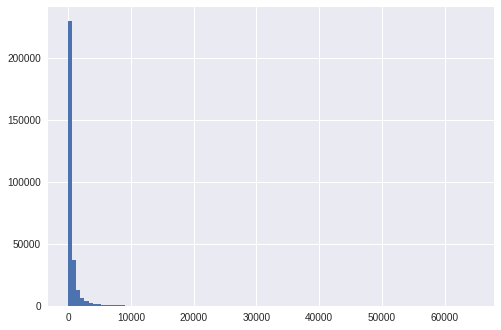

In [139]:
_=plt.hist(bidprice1.reshape(300000),bins=100)

In [0]:
for i in range(30):
  click1[i]=click1[i,np.argsort(click_prediction1[i])]
  payprice1[i]=payprice1[i,np.argsort(click_prediction1[i])]
  bidprice1[i]=bidprice1[i,np.argsort(click_prediction1[i])]
  marketprice1[i]=marketprice1[i,np.argsort(click_prediction1[i])]
  click_prediction1[i]=click_prediction1[i,np.argsort(click_prediction1[i])]

In [0]:
click1=click1.reshape(30,10,1000)
payprice1=payprice1.reshape(30,10,1000)
marketprice1=marketprice1.reshape(30,10,1000)
bidprice1=bidprice1.reshape(30,10,1000)
click_prediction1=click_prediction1.reshape(30,10,1000)

In [0]:
click1=np.flipud(np.mean(click1,axis=-1).T)
payprice1=np.flipud(np.mean(payprice1,axis=-1).T)
marketprice1=np.flipud(np.mean(marketprice1,axis=-1).T)
bidprice1=np.flipud(np.mean(bidprice1,axis=-1).T)
click_prediction1=np.flipud(np.mean(click_prediction1,axis=-1).T)

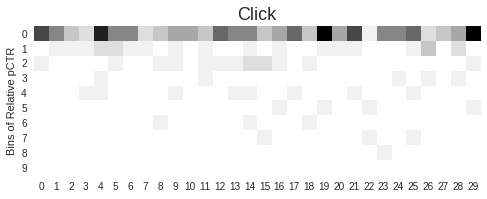

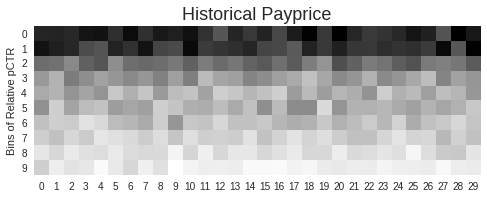

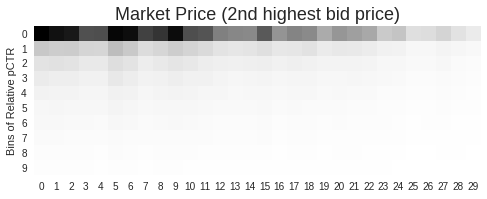

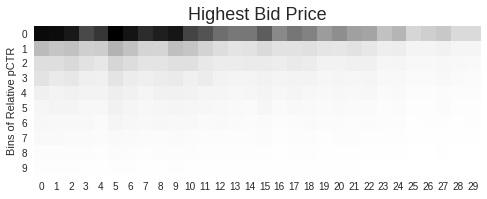

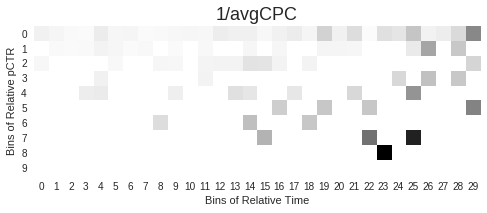

In [190]:
# _=plt.figure()
# _=plt.imshow(click_prediction1)
_=plt.rcParams.update({'font.size': 24})
_=plt.figure()
_=plt.imshow(click1)
_=plt.title('Click',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

_=plt.figure()
_=plt.imshow(payprice1)
_=plt.title('Historical Payprice',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

_=plt.figure()
_=plt.imshow(marketprice1)
_=plt.title('Market Price (2nd highest bid price)',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

_=plt.figure()
_=plt.imshow(bidprice1)
_=plt.title('Highest Bid Price',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

# a=marketprice1/click1
# a[np.isnan(a)]

_=plt.figure()
_=plt.imshow(click1/bidprice1)
_=plt.title('1/avgCPC',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

_=plt.xlabel('Bins of Relative Time')

In [0]:
dic_colors={0:'b',1:'g',2:'r',3:'c',4:'m'}

In [0]:
_=plt.figure(figsize=(12,8))
a=bidprices[-1].copy()
# bidprice1=np.amax(a,axis=-1)
# a[a==np.amax(a,axis=-1,keepdims=True)]=-1
# marketprice1=np.amax(a,axis=-1)
a=np.clip(a,0,30000)
for i in range(len(a)):
  if i%100000==0:
    print(i)
  if np.argmax(a[i])<6 and np.argmax(a[i])>0:
    if np.random.rand()<0.1:
      _=plt.scatter(i,np.amax(a[i]),color=dic_colors[np.argmax(a[i])-1],s=0.001*(np.log(np.amax(a[i]))**5))
_=plt.title('1/avgCPC',fontsize=18)
_=plt.ylabel('Bins of Relative pCTR')
_=plt.xticks(range(30))
_=plt.yticks(range(10))
_=plt.grid(False)

_=plt.xlabel('Bins of Relative Time')

0
100000
200000


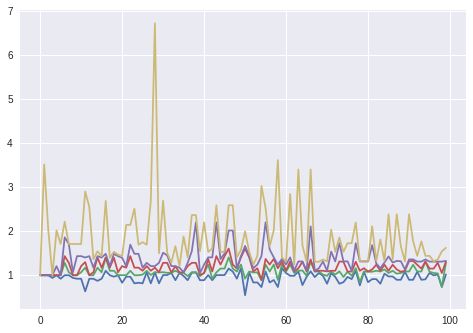

In [176]:
b=np.zeros([100,5])
for i in range(100):
  for j in range(5):
    b[i,j]=agents[i][j].basebid
  b[i]=b[i,np.argsort(b[i])]
b/=50000
  
for i in range(5):
  _=plt.plot(range(100),b[:,i])